In [14]:
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense, LSTM

from math import sqrt
from numpy import concatenate

In [15]:
# load df for lstm model
# inputs: stock group ID, revenue, time
# inner join invoice ID, stock ID
# str_sql = '''
# SELECT invoices.InvoiceDate, (invoicelines.Quantity * invoicelines.UnitPrice) AS Revenue, stockitemstockgroups.StockItemID, stockitemstockgroups.StockGroupID, stockitemholdings.LastCostPrice AS CostPrice
# FROM invoicelines
#     INNER JOIN invoices ON invoicelines.InvoiceID = invoices.ï»¿InvoiceID
#     INNER JOIN stockitemstockgroups ON invoicelines.StockItemID = stockitemstockgroups.StockItemID
#     INNER JOIN stockitemholdings ON invoicelines.StockItemID = stockitemholdings.StockItemID
# ORDER BY invoices.ï»¿InvoiceID ASC;
# '''
# inputs_df = pd.read_sql(sql=str_sql, con=db_wwi)
# inputs_df
# inputs_df.to_csv('data_with_stockItemID.csv', index=False)

In [16]:
ini_df = pd.read_csv('denormalised.csv')
ini_df

,Unnamed: 0,InvoiceLineID,InvoiceID,StockItemID,CustomerID,Quantity,UnitPrice,InvoiceDate,InvoiceDateYear,InvoiceDateMonth,...,InvoiceDateWeek,StockItemName,StockGroupID,StockGroupName,Brand,Size,CostPrice,CustomerName,CustomerCategoryID,CustomerCategoryName
0,0,1,1,67,832,10,230.0,2013-01-01,2013,1,...,0,Ride on toy sedan car (Black) 1/12 scale,1,Novelty Items,Northwind,1/12 scale,145.0,Aakriti Byrraju,4,Supermarket
1,1,1,1,67,832,10,230.0,2013-01-01,2013,1,...,0,Ride on toy sedan car (Black) 1/12 scale,9,Toys,Northwind,1/12 scale,145.0,Aakriti Byrraju,4,Supermarket
2,2,2,2,50,803,9,13.0,2013-01-01,2013,1,...,0,Developer joke mug - old C developers never di...,1,Novelty Items,NaN,NaN,4.5,Bala Dixit,3,Novelty Shop
3,3,2,2,50,803,9,13.0,2013-01-01,2013,1,...,0,Developer joke mug - old C developers never di...,3,Mugs,NaN,NaN,4.5,Bala Dixit,3,Novelty Shop
4,4,2,2,50,803,9,13.0,2013-01-01,2013,1,...,0,Developer joke mug - old C developers never di...,6,Computing Novelties,NaN,NaN,4.5,Bala Dixit,3,Novelty Shop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309289,309289,156390,48177,53,1024,6,13.0,2015-05-30,2015,5,...,21,IT joke mug - keyboard not found … press F1 to...,3,Mugs,NaN,NaN,4.5,Arka Chatterjee,4,Supermarket
309290,309290,156390,48177,53,1024,6,13.0,2015-05-30,2015,5,...,21,IT joke mug - keyboard not found … press F1 to...,6,Computing Novelties,NaN,NaN,4.5,Arka Chatterjee,4,Supermarket
309291,309291,156391,48178,214,847,1,90.0,2015-05-30,2015,5,...,21,Air cushion film 200mmx200mm 325m,10,Packaging Materials,NaN,325m,54.0,Kristiina Ivanov,5,Computer Store
309292,309292,156392,48178,61,847,8,25.0,2015-05-30,2015,5,...,21,RC toy sedan car with remote control (Green) 1...,1,Novelty Items,Northwind,1/50 scale,12.5,Kristiina Ivanov,5,Computer Store


In [17]:
df_revenue = ini_df.loc[:, ['Quantity', 'UnitPrice', 'InvoiceDateYear', 'InvoiceDateMonth', 'StockItemID', 'StockGroupID']]
df_revenue['Revenue'] = df_revenue.Quantity * df_revenue.UnitPrice

df_revenue.drop(["Quantity", "UnitPrice"], axis = 1, inplace= True)
df_revenue

,InvoiceDateYear,InvoiceDateMonth,StockItemID,StockGroupID,Revenue
0,2013,1,67,1,2300.0
1,2013,1,67,9,2300.0
2,2013,1,50,1,117.0
3,2013,1,50,3,117.0
4,2013,1,50,6,117.0
...,...,...,...,...,...
309289,2015,5,53,3,78.0
309290,2015,5,53,6,78.0
309291,2015,5,214,10,90.0
309292,2015,5,61,1,200.0


In [18]:
df_revenue_agg = df_revenue.groupby(['StockGroupID', 'StockItemID', 'InvoiceDateYear', 'InvoiceDateMonth' ]).sum()
df_revenue_agg

Revenue
StockGroupID StockItemID InvoiceDateYear InvoiceDateMonth          
1            1           2013            1                   3275.0
                                         2                   2600.0
                                         3                   2875.0
                                         4                   3100.0
                                         5                   2975.0
...                                                             ...
10           219         2015            1                 102000.0
                                         2                  70000.0
                                         3                  64500.0
                                         4                  77500.0
                                         5                  48000.0

[12586 rows x 1 columns]

In [19]:
df_features = ini_df[['StockItemID', 'StockGroupID', 'CostPrice']] #brand alot none
df_features.drop_duplicates()
df_features

,StockItemID,StockGroupID,CostPrice
0,67,1,145.0
1,67,9,145.0
2,50,1,4.5
3,50,3,4.5
4,50,6,4.5
...,...,...,...
309289,53,3,4.5
309290,53,6,4.5
309291,214,10,54.0
309292,61,1,12.5


In [20]:
df2 = df_revenue_agg.reset_index().merge(df_features, on = ['StockItemID','StockGroupID' ], how = 'left').drop_duplicates()
df2.drop(columns=["StockItemID"], inplace = True, axis = 1)
df2

,StockGroupID,InvoiceDateYear,InvoiceDateMonth,Revenue,CostPrice
0,1,2013,1,3275.0,9.5
727,1,2013,2,2600.0,9.5
1454,1,2013,3,2875.0,9.5
2181,1,2013,4,3100.0,9.5
2908,1,2013,5,2975.0,9.5
...,...,...,...,...,...
8966081,10,2015,1,102000.0,26.0
8966770,10,2015,2,70000.0,26.0
8967459,10,2015,3,64500.0,26.0
8968148,10,2015,4,77500.0,26.0


In [21]:
#one hot encode for categories month and stockitemgroupid
df_encoded = pd.get_dummies(df2, columns=['InvoiceDateMonth','StockGroupID'])
df_encoded

,InvoiceDateYear,Revenue,CostPrice,InvoiceDateMonth_1,InvoiceDateMonth_2,InvoiceDateMonth_3,InvoiceDateMonth_4,InvoiceDateMonth_5,InvoiceDateMonth_6,InvoiceDateMonth_7,...,InvoiceDateMonth_12,StockGroupID_1,StockGroupID_2,StockGroupID_3,StockGroupID_4,StockGroupID_6,StockGroupID_7,StockGroupID_8,StockGroupID_9,StockGroupID_10
0,2013,3275.0,9.5,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
727,2013,2600.0,9.5,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1454,2013,2875.0,9.5,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2181,2013,3100.0,9.5,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2908,2013,2975.0,9.5,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8966081,2015,102000.0,26.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8966770,2015,70000.0,26.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8967459,2015,64500.0,26.0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8968148,2015,77500.0,26.0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [22]:
# rearrange df to have Revenue as first col and drop year column
cols = list(df_encoded.columns)
cols.insert(0, cols.pop(cols.index('Revenue')))
df = df_encoded[cols]
df.drop(columns=["InvoiceDateYear"], inplace = True, axis = 1)
df

C:\Users\tongt\AppData\Local\Temp\ipykernel_16252\1312628853.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=["InvoiceDateYear"], inplace = True, axis = 1)


,Revenue,CostPrice,InvoiceDateMonth_1,InvoiceDateMonth_2,InvoiceDateMonth_3,InvoiceDateMonth_4,InvoiceDateMonth_5,InvoiceDateMonth_6,InvoiceDateMonth_7,InvoiceDateMonth_8,...,InvoiceDateMonth_12,StockGroupID_1,StockGroupID_2,StockGroupID_3,StockGroupID_4,StockGroupID_6,StockGroupID_7,StockGroupID_8,StockGroupID_9,StockGroupID_10
0,3275.0,9.5,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
727,2600.0,9.5,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1454,2875.0,9.5,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2181,3100.0,9.5,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2908,2975.0,9.5,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8966081,102000.0,26.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8966770,70000.0,26.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8967459,64500.0,26.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8968148,77500.0,26.0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [23]:
# convert series to supervised learning
def series_to_supervised(data, n_in, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
        # put it all together
        agg = pd.concat(cols, axis=1)
        agg.columns = names
        # drop rows with NaN values
        if dropnan:
            agg.dropna(inplace=True)
    return agg
    
# load inputs_df
values = df.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning, lag data for previous 3 months
n_months = 3
reframed = series_to_supervised(scaled, n_months, 1)
# drop columns we don't want to predict
# we want to predict revenue, which is var1
ref = reframed.drop(reframed.columns[70:], axis=1, inplace=False)
ref

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var7(t-3),var8(t-3),var9(t-3),var10(t-3),...,var15(t-1),var16(t-1),var17(t-1),var18(t-1),var19(t-1),var20(t-1),var21(t-1),var22(t-1),var23(t-1),var1(t)
3,0.006985,0.008020,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006539
4,0.005265,0.008020,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006221
5,0.005966,0.008020,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007176
6,0.006539,0.008020,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.009978
7,0.006221,0.008020,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12581,0.137475,0.022498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.258475
12582,0.196064,0.022498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.176959
12583,0.113274,0.022498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.162948
12584,0.258475,0.022498,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.196064


In [30]:
df_randomized = ref.sample(frac=1, random_state=2024)

# split into train and test sets
values = ref.values
n_rows = len(df_randomized)
train_size = int(0.8 * n_rows)
train = values[:train_size, :]
test = values[train_size:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(10066, 1, 69) (10066,) (2517, 1, 69) (2517,)


c:\Users\tongt\OneDrive\Documents\Kei\NUS\Mods\Y3S2\BT4301\Group Project\env\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
140/140 - 7s - 50ms/step - loss: 0.0301 - val_loss: 0.0577
Epoch 2/50
140/140 - 1s - 5ms/step - loss: 0.0340 - val_loss: 0.0492
Epoch 3/50
140/140 - 1s - 5ms/step - loss: 0.0252 - val_loss: 0.0619
Epoch 4/50
140/140 - 1s - 7ms/step - loss: 0.0328 - val_loss: 0.0524
Epoch 5/50
140/140 - 1s - 7ms/step - loss: 0.0219 - val_loss: 0.0420
Epoch 6/50
140/140 - 1s - 9ms/step - loss: 0.0207 - val_loss: 0.0403
Epoch 7/50
140/140 - 1s - 5ms/step - loss: 0.0281 - val_loss: 0.0400
Epoch 8/50
140/140 - 1s - 6ms/step - loss: 0.0219 - val_loss: 0.0335
Epoch 9/50
140/140 - 1s - 6ms/step - loss: 0.0182 - val_loss: 0.0353
Epoch 10/50
140/140 - 1s - 5ms/step - loss: 0.0215 - val_loss: 0.0287
Epoch 11/50
140/140 - 1s - 6ms/step - loss: 0.0162 - val_loss: 0.0280
Epoch 12/50
140/140 - 1s - 6ms/step - loss: 0.0190 - val_loss: 0.0249
Epoch 13/50
140/140 - 1s - 5ms/step - loss: 0.0146 - val_loss: 0.0247
Epoch 14/50
140/140 - 1s - 6ms/step - loss: 0.0162 - val_loss: 0.0306
Epoch 15/50
140/140 - 1s - 6

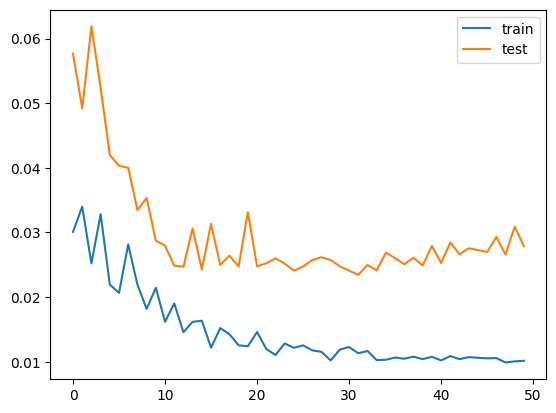

In [31]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [32]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -22:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -22:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
Test RMSE: 25479.349
